In [1]:
import pandas as pd
import numpy as np

import altair as alt
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Feature Importance: Indicators of Wealth (US vs. World)

In [2]:
df = pd.read_csv(filepath_or_buffer='/kaggle/input/billionaires-statistics-dataset/Billionaires Statistics Dataset.csv')
df.drop(['date'], inplace=True, axis=1)

print("\nBillionaires in the world: ", len(df))
billionaires_by_country = df.groupby(['country'])['personName'].count().sort_values(ascending=False)
print("Countries with billionaires: ", len(billionaires_by_country))

print("\nAll Features: ", "\n", df.columns.values)


Billionaires in the world:  2640
Countries with billionaires:  78

All Features:  
 ['rank' 'finalWorth' 'category' 'personName' 'age' 'country' 'city'
 'source' 'industries' 'countryOfCitizenship' 'organization' 'selfMade'
 'status' 'gender' 'birthDate' 'lastName' 'firstName' 'title' 'state'
 'residenceStateRegion' 'birthYear' 'birthMonth' 'birthDay' 'cpi_country'
 'cpi_change_country' 'gdp_country' 'gross_tertiary_education_enrollment'
 'gross_primary_education_enrollment_country' 'life_expectancy_country'
 'tax_revenue_country_country' 'total_tax_rate_country'
 'population_country' 'latitude_country' 'longitude_country']


In [3]:
print("Categorical Data Summary: ")
df.select_dtypes(['O', 'bool']).describe().T

Categorical Data Summary: 


,count,unique,top,freq
category,2640,18,Finance & Investments,372
personName,2640,2638,Wang Yanqing & family,2
country,2602,78,United States,754
city,2568,741,New York,99
source,2640,906,Real estate,151
industries,2640,18,Finance & Investments,372
countryOfCitizenship,2640,77,United States,735
organization,325,294,Meta Platforms,4
selfMade,2640,2,True,1812
status,2640,6,D,1223


In [4]:
print("Numerical Data Summary: ")
df.describe(percentiles=[]).T

Numerical Data Summary: 


,count,mean,std,min,50%,max
rank,2640.0,1.289159e+03,7.396937e+02,1.000000,1.312000e+03,2.540000e+03
finalWorth,2640.0,4.623788e+03,9.834241e+03,1000.000000,2.300000e+03,2.110000e+05
age,2575.0,6.514019e+01,1.325810e+01,18.000000,6.500000e+01,1.010000e+02
birthYear,2564.0,1.957183e+03,1.328252e+01,1921.000000,1.957000e+03,2.004000e+03
birthMonth,2564.0,5.740250e+00,3.710085e+00,1.000000,6.000000e+00,1.200000e+01
birthDay,2564.0,1.209984e+01,9.918876e+00,1.000000,1.100000e+01,3.100000e+01
cpi_country,2456.0,1.277552e+02,2.645295e+01,99.550000,1.172400e+02,2.885700e+02
cpi_change_country,2456.0,4.364169e+00,3.623763e+00,-1.900000,2.900000e+00,5.350000e+01
gross_tertiary_education_enrollment,2458.0,6.722567e+01,2.134343e+01,4.000000,6.560000e+01,1.366000e+02
gross_primary_education_enrollment_country,2459.0,1.028585e+02,4.710977e+00,84.700000,1.018000e+02,1.421000e+02


Features removed  && Why???


* km

In [5]:
wealth_df = df.drop(["rank", "personName", "source", "organization", "title", "status", "birthDate", "firstName", "lastName",
                    "longitude_country", "latitude_country", "birthMonth", "birthDay", "residenceStateRegion"], axis=1)
wealth_df['gdp_country'] = wealth_df['gdp_country'].str.replace('$','').replace(',','', regex=True).astype(float)
wealth_df = wealth_df.dropna()

print("Numerical Features:")
numerical_features = wealth_df.describe(include=np.number).columns.values
print(numerical_features)

print("\nCategorical Features:")
categorical_features = wealth_df.describe(include=['O']).columns.values
print(categorical_features)

Numerical Features:
['finalWorth' 'age' 'birthYear' 'cpi_country' 'cpi_change_country'
 'gdp_country' 'gross_tertiary_education_enrollment'
 'gross_primary_education_enrollment_country' 'life_expectancy_country'
 'tax_revenue_country_country' 'total_tax_rate_country'
 'population_country']

Categorical Features:
['category' 'country' 'city' 'industries' 'countryOfCitizenship' 'gender'
 'state']


In [6]:
x = wealth_df.drop(columns=['selfMade'])
y = wealth_df.selfMade.astype('int')

transformer = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features), sparse_threshold=0)
transformed_data = transformer.fit_transform(x)

feature_names = [name.split("__")[-1] for name in transformer.get_feature_names_out()]
X = pd.DataFrame(transformed_data, columns=feature_names)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Training set size: ", len(X_train))
print("Testing set size: ", len(X_test))

print("\nSelf made billionaires: ", len(wealth_df[wealth_df.selfMade == 1]))
print("Inherited billionaires: ", len(wealth_df[wealth_df.selfMade == 0]))

Training set size:  562
Testing set size:  188

Self made billionaires:  537
Inherited billionaires:  213


In [7]:
rfe_cv = RFECV(
    estimator=LogisticRegression(),
    step=1,
    cv=StratifiedKFold(5),
    scoring="accuracy",
    min_features_to_select=1,
    n_jobs=-1
)

rfe_cv.fit(X,y)
print(rfe_cv.n_features_)

2


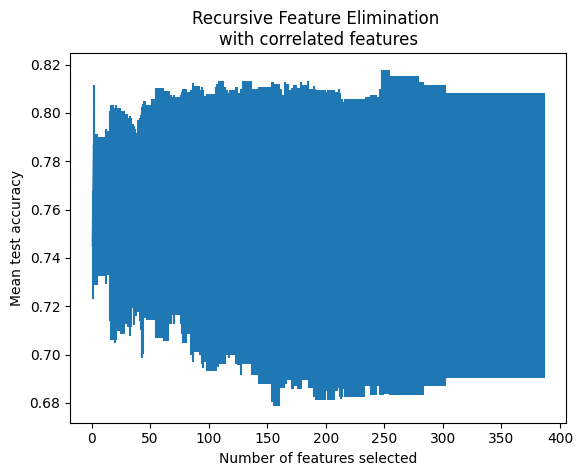

In [8]:
n_scores = len(rfe_cv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfe_cv.cv_results_["mean_test_score"],
    yerr=rfe_cv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()